In [1]:
from algorithm_ranking import MeasurementsSimulator, MeasurementsVisualizer, CompareAlgs, RankVariants

In [2]:
import pandas as pd
import graphviz
import numpy as np

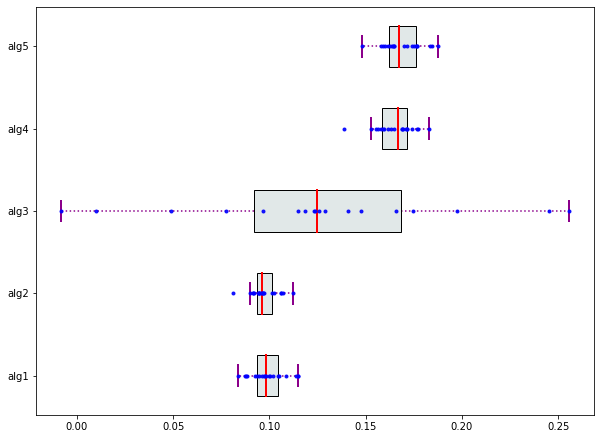

In [71]:
cfg = {}
cfg['alg1']  = [0.1,0.01] # [mean, std]
cfg['alg2']  = [0.1,0.01]
cfg['alg3']  = [0.15,0.1]
cfg['alg4']  = [0.17,0.01]
cfg['alg5']  = [0.17,0.01]
h0 = list(cfg.keys())

ms = MeasurementsSimulator(cfg, 'normal',seed=129)    
rep_steps = 20
run_id= 1
ms.measure(rep_steps=rep_steps, run_id=run_id)

mv = MeasurementsVisualizer(ms.get_alg_measurements(), h0)
fig = mv.show_measurements_boxplots()

In [72]:
class Node:
    def __init__(self,name):
        self.name = name
        self.in_nodes = set()
        self.out_nodes = set()
        self.redun = set()
        self.depth = -1
        
    def add_in_node(self, node):
        self.in_nodes.add(node)
        
    def remove_in_node(self, node):
        self.in_nodes.remove(node)
        
    def add_out_node(self, node):
        self.out_nodes.add(node)
        
    def remove_out_node(self, node):
        self.out_nodes.remove(node)
        
    def get_depth(self):
        if self.depth == -1:
            depth = 0
            if self.in_nodes:
                depth = max([ n.get_depth() + 1 for n in self.in_nodes])
            self.depth = depth
        return self.depth
    
    
    def get_depth_n_collect_redun(self):
        self.redun = set()
        depths = []
        nodes = []
        max_depth = 0
        if self.in_nodes:
            for n in self.in_nodes:
                depths.append(n.get_depth_n_collect_redun()+1)
                nodes.append(n.name)
            max_depth = max(depths)
            idxs = np.where(np.array(depths) != max_depth)[0]
            for i in idxs:
                self.redun.add(nodes[i])
        self.depth = max_depth
        return self.depth
        
    def depth(self):
        self.redun = set()
        depths = []
        nodes = []
        max_depth = 0
        if self.in_nodes:
            for n in self.in_nodes:
                depths.append(n.depth()+1)
                nodes.append(n.name)
            max_depth = max(depths)
            idxs = np.where(np.array(depths) != max_depth)[0]
            for i in idxs:
                self.redun.add(nodes[i])
        return max_depth
                    
                          
    def __str__(self):
        return "{}".format(self.name)

class Graph:
    def __init__(self,debug=False):
        self.nodes = {}
        self.edges_in = {}
        self.edges_out = {}
        self.node_depth = {}
        self.graph_depth = 0
        self.debug = debug
    
    def add_node(self,node):
        self.nodes[node]  = Node(node)
        self.edges_in[node] = []
        self.edges_out[node] = []
        self.node_depth[node] = 0
        
        
    def add_edge(self, node_x, node_y):
        if node_y not in self.edges_out[node_x]:
            if self.debug:
                print("Adding edge from {} to {}".format(node_x,node_y))
            self.edges_out[node_x].append(node_y)
            self.nodes[node_x].add_out_node(self.nodes[node_y])

            self.edges_in[node_y].append(node_x)
            self.nodes[node_y].add_in_node(self.nodes[node_x])
    
        
    def remove_edge(self, node_x, node_y):
        if self.debug:
            print("Removing edge from {} to {}".format(node_x,node_y))
        try:
            self.edges_out[node_x].remove(node_y)
            self.nodes[node_x].remove_out_node(self.nodes[node_y])    
            
            self.edges_in[node_y].remove(node_x)
            self.nodes[node_y].remove_in_node(self.nodes[node_x]) 
            
        except ValueError:
            print("Edge does not exist")
     
    def reset_node_depths(self):
        for alg,node in self.nodes.items():
            node.depth = -1
    
    def calculate_node_depth(self):
        self.reset_node_depths()
        self.graph_depth = 0
        for alg,node in self.nodes.items():
            self.node_depth[alg] = node.get_depth()
            if self.graph_depth < self.node_depth[alg]:
                self.graph_depth = self.node_depth[alg]
            
    def transitivity_reduction(self):
        self.reset_node_depths()
        self.graph_depth = 0
        for alg,node in self.nodes.items():
            if node.depth == -1:
                self.node_depth[alg] = node.get_depth_n_collect_redun()
            else:
                self.node_depth[alg] = node.depth
                
            if self.graph_depth < self.node_depth[alg]:
                self.graph_depth = self.node_depth[alg]
                
        for alg,node in self.nodes.items():
            for in_node in node.redun:
                self.remove_edge(in_node,node.name)
            
    def get_nodes_at_depth(self,depth):
        #self.calculate_node_depth()
        df = pd.DataFrame(self.node_depth.items())
        return list(df.loc[df[1] == depth][0])
    
    def visualize(self,highlight_nodes=[]):
        g = graphviz.Digraph()
        for node in self.nodes.keys():
            color='#f0efed'
            if node in highlight_nodes:
                color = '#f2ecc7'
            g.node(node,style='filled',color=color)
        for node1,v in self.edges_out.items():
            for node2 in v:
                if node2 in highlight_nodes:
                    g.edge(node1, node2, style='filled', color='blue')
                else:
                    g.edge(node1, node2)
        return g

In [96]:
class RankVariantsDFGBrute(RankVariants):
    def __init__(self, alg_measurements, alg_seq_h0):
        super().__init__(alg_measurements, alg_seq_h0)
        
        self.graph = None
        self.algs_ft = {}
        self.init_graph()
        

        
    def init_graph(self,debug=False):
        self.graph = Graph(debug)

        for alg in self.alg_seq_h0:
            self.graph.add_node(alg)
            self.algs_ft[alg] = []
        #self.graph.calculate_node_depth()
            
            
        
    def rank_variants(self, q_max=75, q_min=25, debug = False, redo_comparisons = True):
        
        if redo_comparisons:
            self.init_graph(debug)
            self.compare_algs.init_comparision_matrix()
        
        N = len(self.alg_seq_h0)
        for i in range(N):
            for j in range(0, N-i-1):
                
                alg_i =  self.alg_seq_h0[j]
                alg_j =  self.alg_seq_h0[j+i+1]
                
                #self.deduce_transitivity(j, j+i+1)
                #self.deduce_transitivity(alg_i, alg_j)
                
                self.deduce_transitivity(alg_i,alg_j)
                
                if self.compare_algs.comparision_matrix[alg_i][alg_j] != -1:
                    continue
                
                if debug:
                    print("comparing {} and {}".format(alg_i, alg_j))
                    
                ret = self.compare_algs.compare(alg_i, alg_j, q_max, q_min)
                
                if ret == 0:
                    self.graph.add_edge(alg_i, alg_j)
                    self.algs_ft[alg_j] = self.algs_ft[alg_j] + [alg_i] + self.algs_ft[alg_i]
                elif ret == 2:
                    self.graph.add_edge(alg_j, alg_i)
                    self.algs_ft[alg_i] = self.algs_ft[alg_i] + [alg_j] + self.algs_ft[alg_j]
                        
                
            #self.graph.calculate_node_depth()
            
        return self.get_ranks_from_graph(q_max,q_min)
    
    
    def deduce_transitivity(self, alg_i, alg_j):
        if alg_i in self.algs_ft[alg_j]:
            self.compare_algs.comparision_matrix[alg_i][alg_j] = 'd'
            self.compare_algs.comparision_matrix[alg_j][alg_i] = 'd'
            
        elif alg_j in self.algs_ft[alg_i]:
            self.compare_algs.comparision_matrix[alg_i][alg_j] = 'd'
            self.compare_algs.comparision_matrix[alg_j][alg_i] = 'd'
            
    
#     def deduce_transitivity(self,alg_i,alg_j):
#         if self.graph.node_depth[alg_i] != self.graph.node_depth[alg_j]:
#             self.compare_algs.comparision_matrix[alg_i][alg_j] = 'd'
#             self.compare_algs.comparision_matrix[alg_j][alg_i] = 'd'
        
        
        
#     def deduce_transitivity1(self, x, y):
        
#         cx = self.compare_algs.comparision_matrix[self.alg_seq_h0[x]][self.alg_seq_h0[y-1]]
#         cy = self.compare_algs.comparision_matrix[self.alg_seq_h0[y-1]][self.alg_seq_h0[y]]
        
#         if cx == cy == 0:
#             self.compare_algs.comparision_matrix[self.alg_seq_h0[x]][self.alg_seq_h0[y]] = 0
#             self.compare_algs.comparision_matrix[self.alg_seq_h0[y]][self.alg_seq_h0[x]] = 2
#         elif cx == cy == 2:
#             self.compare_algs.comparision_matrix[self.alg_seq_h0[y]][self.alg_seq_h0[x]] = 0
#             self.compare_algs.comparision_matrix[self.alg_seq_h0[x]][self.alg_seq_h0[y]] = 2
            
    def get_ranks_from_graph(self,q_max,q_min):
        
        self.graph.transitivity_reduction()
        
        algs_sorted = []
        alg_ranks = []
        
        for rank in range(self.graph.graph_depth + 1):
            for alg in self.graph.get_nodes_at_depth(rank):
                algs_sorted.append(alg)
                alg_ranks.append(rank)
                
        
        columns = ['case:concept:name', 'case:rank:q{}-q{}'.format(int(q_max),int(q_min))]
        return pd.DataFrame([(algs_sorted[i], alg_ranks[i]) for i in range(len(alg_ranks))], columns=columns)
            


In [97]:
rv = RankVariantsDFGBrute(ms.get_alg_measurements(), h0)

In [98]:
rv.rank_variants(q_max=70,q_min=30,debug=True)

comparing alg1 and alg2
Adding edge from alg1 to alg2
comparing alg2 and alg3
Adding edge from alg2 to alg3
comparing alg3 and alg4
Adding edge from alg3 to alg4
comparing alg4 and alg5
Adding edge from alg4 to alg5


,case:concept:name,case:rank:q70-q30
0,alg1,0
1,alg2,1
2,alg3,2
3,alg4,3
4,alg5,4


In [99]:
pd.DataFrame(rv.compare_algs.comparision_matrix)

,alg1,alg2,alg3,alg4,alg5
alg1,-1,2,d,d,d
alg2,0,-1,2,d,d
alg3,d,0,-1,2,d
alg4,d,d,0,-1,2
alg5,d,d,d,0,-1


In [100]:
rv.compare_algs.num_comparisons

4

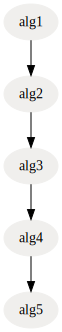

In [101]:
rv.graph.visualize()

In [102]:
rv.graph.node_depth

{'alg1': 0, 'alg2': 1, 'alg3': 2, 'alg4': 3, 'alg5': 4}

In [103]:
rv.graph.graph_depth

4

In [104]:
df_ranks, df_mean = rv.calculate_mean_rank()

In [105]:
df_ranks

,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35,case:rank:q55-q45
case:concept:name,,,,,,,,
alg1,0,0,0,0,0,0,0,0
alg2,1,1,1,1,1,1,1,1
alg3,2,2,2,2,2,2,2,2
alg4,3,3,3,3,3,3,3,3
alg5,4,4,4,4,4,4,4,4


In [83]:
df_mean

,case:concept:name,case:mean-rank
1,alg2,0.000
0,alg1,0.125
2,alg3,0.500
3,alg4,1.500
4,alg5,1.500


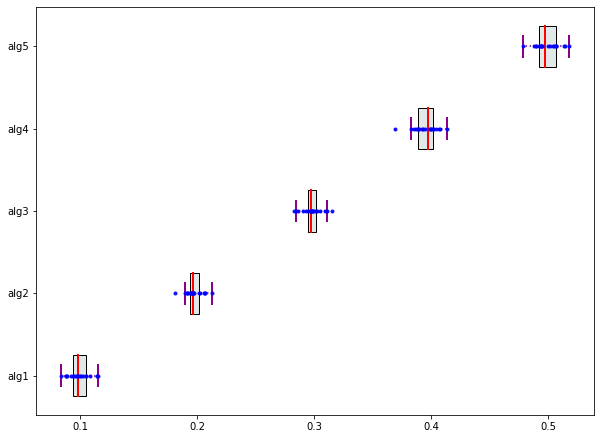

In [91]:
cfg = {}
cfg['alg1']  = [0.1,0.01] # [mean, std]
cfg['alg2']  = [0.2,0.01]
cfg['alg3']  = [0.3,0.01]
cfg['alg4']  = [0.4,0.01]
cfg['alg5']  = [0.5,0.01]
h0 = list(cfg.keys())

ms = MeasurementsSimulator(cfg, 'normal',seed=129)    
rep_steps = 20
run_id= 1
ms.measure(rep_steps=rep_steps, run_id=run_id)

mv = MeasurementsVisualizer(ms.get_alg_measurements(), h0)
fig = mv.show_measurements_boxplots()

In [92]:
compareAlgs = CompareAlgs(ms.get_alg_measurements(), h0)
print(h0)

['alg1', 'alg2', 'alg3', 'alg4', 'alg5']


In [93]:
rv = RankVariantsDFGBrute(ms.get_alg_measurements(), h0)
rv.rank_variants()
pd.DataFrame(rv.compare_algs.comparision_matrix)

,alg1,alg2,alg3,alg4,alg5
alg1,-1,2,d,d,d
alg2,0,-1,2,d,d
alg3,d,0,-1,2,d
alg4,d,d,0,-1,2
alg5,d,d,d,0,-1


In [94]:
rv.compare_algs.num_comparisons

4

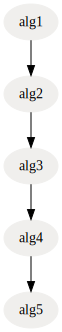

In [95]:
rv.graph.visualize()

In [89]:
k= 5
n = 0
for i in range(k):
    for j in range(0,k-i-1):
        print(j+1,j+2+i)
        n = n+1
print(n)
print(k*(k-1)/2.)

1 2
2 3
3 4
4 5
1 3
2 4
3 5
1 4
2 5
1 5
10
10.0


In [90]:
rv.algs_ft

{'alg1': [],
 'alg2': ['alg1'],
 'alg3': ['alg2', 'alg1'],
 'alg4': ['alg3', 'alg2', 'alg1'],
 'alg5': ['alg4', 'alg3', 'alg2', 'alg1']}